In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df_raw = pd.read_pickle("data/preprocessed_data.pkl")

In [3]:
df_raw.shape

(100000, 307)

In [4]:
y = df_raw["los"]

features = [
    "age",
    "size",
    # "organization_name",
    # "published_at",
    # "status_changed_at",
    # "los",
    # "breed_secondary",
    "breed_mixed",
    "good_with_children",
    "good_with_dogs",
    "good_with_cats",
    "attribute_spayed_neutered",
    "attribute_house_trained",
    "attribute_special_needs",
    "attribute_shots_current",
    "breed_primary_Akita",
    "breed_primary_Alaskan Malamute",
    "breed_primary_American Bulldog",
    "breed_primary_American Eskimo Dog",
    "breed_primary_American Staffordshire Terrier",
    "breed_primary_Australian Cattle Dog / Blue Heeler",
    "breed_primary_Australian Shepherd",
    "breed_primary_Basenji",
    "breed_primary_Beagle",
    "breed_primary_Belgian Shepherd / Malinois",
    "breed_primary_Bichon Frise",
    "breed_primary_Black Labrador Retriever",
    "breed_primary_Black and Tan Coonhound",
    "breed_primary_Border Collie",
    "breed_primary_Border Terrier",
    "breed_primary_Boston Terrier",
    "breed_primary_Boxer",
    "breed_primary_Brussels Griffon",
    "breed_primary_Bull Terrier",
    "breed_primary_Cairn Terrier",
    "breed_primary_Cane Corso",
    "breed_primary_Cattle Dog",
    "breed_primary_Cavalier King Charles Spaniel",
    "breed_primary_Chihuahua",
    "breed_primary_Chow Chow",
    "breed_primary_Cocker Spaniel",
    "breed_primary_Collie",
    "breed_primary_Corgi",
    "breed_primary_Dachshund",
    "breed_primary_Dalmatian",
    "breed_primary_Dandie Dinmont Terrier",
    "breed_primary_Doberman Pinscher",
    "breed_primary_English Bulldog",
    "breed_primary_Fox Terrier",
    "breed_primary_French Bulldog",
    "breed_primary_German Shepherd Dog",
    "breed_primary_German Shorthaired Pointer",
    "breed_primary_Golden Retriever",
    "breed_primary_Goldendoodle",
    "breed_primary_Great Dane",
    "breed_primary_Great Pyrenees",
    "breed_primary_Greyhound",
    "breed_primary_Havanese",
    "breed_primary_Hound",
    "breed_primary_Husky",
    "breed_primary_Jack Russell Terrier",
    "breed_primary_Labrador Retriever",
    "breed_primary_Lhasa Apso",
    "breed_primary_Maltese",
    "breed_primary_Manchester Terrier",
    "breed_primary_Mastiff",
    "breed_primary_Miniature Pinscher",
    "breed_primary_Miniature Schnauzer",
    "breed_primary_Pekingese",
    "breed_primary_Pembroke Welsh Corgi",
    "breed_primary_Pit Bull Terrier",
    "breed_primary_Pointer",
    "breed_primary_Pomeranian",
    "breed_primary_Poodle",
    "breed_primary_Pug",
    "breed_primary_Rat Terrier",
    "breed_primary_Retriever",
    "breed_primary_Rhodesian Ridgeback",
    "breed_primary_Rottweiler",
    "breed_primary_Saint Bernard",
    "breed_primary_Schipperke",
    "breed_primary_Schnauzer",
    "breed_primary_Shar-Pei",
    "breed_primary_Shepherd",
    "breed_primary_Shetland Sheepdog / Sheltie",
    "breed_primary_Shiba Inu",
    "breed_primary_Shih Tzu",
    "breed_primary_Shih poo",
    "breed_primary_Siberian Husky",
    "breed_primary_Spaniel",
    "breed_primary_Staffordshire Bull Terrier",
    "breed_primary_Terrier",
    "breed_primary_Vizsla",
    "breed_primary_West Highland White Terrier / Westie",
    "breed_primary_Wheaten Terrier",
    "breed_primary_Yellow Labrador Retriever",
    "breed_primary_Yorkshire Terrier",
    "gender_Female",
    "gender_Male",
    "coat_Curly",
    "coat_Long",
    "coat_Medium",
    "coat_Short",
    "coat_Wire",
    "color_primary_Apricot / Beige",
    "color_primary_Bicolor",
    "color_primary_Black",
    "color_primary_Brindle",
    "color_primary_Brown / Chocolate",
    "color_primary_Golden",
    "color_primary_Gray / Blue / Silver",
    "color_primary_Merle (Blue)",
    "color_primary_Merle (Red)",
    "color_primary_Red / Chestnut / Orange",
    "color_primary_Sable",
    "color_primary_Tricolor (Brown, Black, & White)",
    "color_primary_White / Cream",
    "color_primary_Yellow / Tan / Blond / Fawn",
    "color_secondary_Apricot / Beige",
    "color_secondary_Black",
    "color_secondary_Brindle",
    "color_secondary_Brown / Chocolate",
    "color_secondary_Golden",
    "color_secondary_Gray / Blue / Silver",
    "color_secondary_Merle (Blue)",
    "color_secondary_Merle (Red)",
    "color_secondary_Red / Chestnut / Orange",
    "color_secondary_Tricolor (Brown, Black, & White)",
    "color_secondary_White / Cream",
    "color_secondary_Yellow / Tan / Blond / Fawn",
    "color_tertiary_Brown / Chocolate",
    "color_tertiary_Red / Chestnut / Orange",
    "color_tertiary_White / Cream",
    "color_tertiary_Yellow / Tan / Blond / Fawn",
]
X = df_raw[features]


In [18]:
len(features)

129

In [5]:
# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=312)

In [7]:
# set up hyperparameter search space for the random forest regressor
random_grid = {
    "bootstrap": [True, False],
    # "max_depth": [int(x) for x in np.linspace(10, 110, num=11)],
    "max_depth": [10, 20, 40, 60],
    # "max_features": ["auto", "sqrt", "log2"],
    # "max_leaf_nodes": None,
    # "max_samples": None,
    # "min_impurity_decrease": 0.0,
    "min_samples_leaf": [1, 2, 4, 8],
    "min_samples_split": [2, 4, 8, 16],
    # "min_weight_fraction_leaf": 0.0,
    "n_estimators": [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
}

In [8]:
# train the regressor
regr = RandomForestRegressor(max_depth=5, random_state=312, criterion="squared_error")
regr_random = RandomizedSearchCV(estimator=regr, param_distributions=random_grid, n_iter=10, cv=2, random_state=312, n_jobs=-1)

regr_random.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=RandomForestRegressor(max_depth=5,
                                                   random_state=312),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 40, 60],
                                        'min_samples_leaf': [1, 2, 4, 8],
                                        'min_samples_split': [2, 4, 8, 16],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=312)

In [9]:
# print out selected parameters
best_params = regr_random.best_params_

print(regr_random.best_score_)
print(best_params)

0.23817119535591336
{'n_estimators': 1200, 'min_samples_split': 16, 'min_samples_leaf': 4, 'max_depth': 60, 'bootstrap': True}


In [10]:
# retrain using the best params
regr = RandomForestRegressor(n_jobs=-1, random_state=312).set_params(**best_params)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=60, min_samples_leaf=4, min_samples_split=16,
                      n_estimators=1200, n_jobs=-1, random_state=312)

In [11]:
# infer on test data
yhat = regr.predict(X_test)

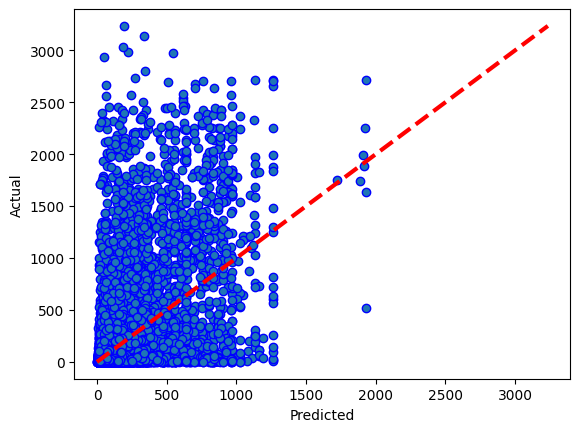

In [12]:
# plot inferences
fig, ax = plt.subplots()
ax.scatter(yhat, y_test, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

In [22]:
(y_train > 365).sum()

4104

In [13]:
feature_importances = pd.Series(regr.feature_importances_, index=regr.feature_names_in_)

In [14]:
display(feature_importances.sort_values(ascending=False).head(20))

coat_Short                                      0.103832
age                                             0.077448
size                                            0.070999
breed_mixed                                     0.060490
good_with_dogs                                  0.059801
coat_Medium                                     0.054810
breed_primary_Pit Bull Terrier                  0.054134
attribute_house_trained                         0.040165
attribute_shots_current                         0.039146
color_primary_Yellow / Tan / Blond / Fawn       0.035066
breed_primary_Labrador Retriever                0.032034
color_primary_Black                             0.030964
color_primary_Brown / Chocolate                 0.023193
attribute_spayed_neutered                       0.022810
color_primary_White / Cream                     0.021150
gender_Female                                   0.019107
attribute_special_needs                         0.018164
gender_Male                    

In [19]:
display(feature_importances.sort_values(ascending=False).tail(20))

breed_primary_Pembroke Welsh Corgi             4.291630e-05
breed_primary_Vizsla                           3.185251e-05
breed_primary_Havanese                         2.863926e-05
color_tertiary_Yellow / Tan / Blond / Fawn     2.419619e-05
breed_primary_Miniature Schnauzer              1.739196e-05
breed_primary_Cane Corso                       1.397688e-05
breed_primary_Cavalier King Charles Spaniel    1.019943e-05
coat_Curly                                     8.376830e-06
breed_primary_French Bulldog                   4.704680e-06
color_primary_Merle (Red)                      4.021087e-06
breed_primary_Brussels Griffon                 3.962350e-06
breed_primary_Belgian Shepherd / Malinois      2.573567e-06
breed_primary_Greyhound                        2.351093e-06
color_tertiary_Brown / Chocolate               1.416484e-06
color_tertiary_Red / Chestnut / Orange         2.175150e-07
color_secondary_Merle (Blue)                   8.792549e-08
color_secondary_Merle (Red)             

In [15]:
# evaluate performance
mse = mean_squared_error(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
r2 = r2_score(y_test, yhat)

metrics_rfr = {
    "mse": mse,
    "mae": mae,
    "r2": r2,
}
# df_metrics = pd.DataFrame.from_dict(metrics, orient="index", columns=["RandomForestRegressor"])

# evaluate a baseline of always guessing the mean
yhat = np.ones((y_test.shape[0],1)) * y_train.mean()
mse = mean_squared_error(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
r2 = r2_score(y_test, yhat)

metrics_baseline = {
    "mse": mse,
    "mae": mae,
    "r2": r2,
}

In [16]:
df_metrics = pd.DataFrame.from_dict(data={"Baseline": metrics_baseline, "RandomForestRegressor": metrics_rfr})

In [17]:
display(df_metrics)

,Baseline,RandomForestRegressor
mse,75310.958513,56963.778901
mae,124.597434,99.373937
r2,-0.000078,0.243560
